In [1]:
import numpy as np
import pandas as pd
import datetime
import scipy
import matplotlib.pyplot as pl
from pandas_datareader import data as pdr
import yfinance as yf
import statsmodels.api as sm
from pandas_datareader.data import DataReader
from statsmodels import regression
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import seaborn as sns

In [4]:
def linear_regression(x,y):
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y,x).fit()
    x = x[:, 1]
    return model.params[0], model.params[1]

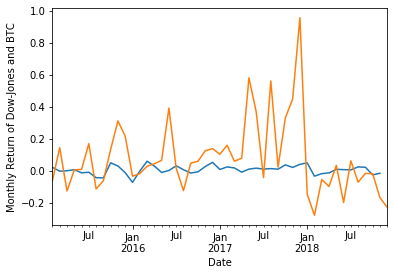

In [5]:
BTC = DataReader('BTC-USD',  'yahoo', '2015-01-01', '2018-12-01')
DOW = DataReader('^DJI',  'yahoo', '2015-01-01', '2018-12-01')
BTC_return_monthly = BTC.groupby(pd.Grouper(freq='MS'))['Adj Close'].mean()
BTC_return_monthly = BTC_return_monthly.pct_change()[1:]
DOW_return_monthly = DOW.groupby(pd.Grouper(freq='MS'))['Adj Close'].mean()
DOW_return_monthly = DOW_return_monthly.pct_change()[1:]
DOW_return_monthly.plot()
BTC_return_monthly.plot()
pl.ylabel("Monthly Return of Dow-Jones and BTC")
pl.show()

In [4]:
BTC_return_monthly = BTC_return_monthly[:46]
if BTC_return_monthly.shape == DOW_return_monthly.shape:
    pass
else:
    raise exception("Shapes don't match.")

In [7]:
BTC_return_monthly

Date
2015-02-01   -0.058802
2015-03-01    0.146093
2015-04-01   -0.124372
2015-05-01    0.007305
2015-06-01    0.010857
2015-07-01    0.171493
2015-08-01   -0.111651
2015-09-01   -0.060636
2015-10-01    0.136188
2015-11-01    0.312748
2015-12-01    0.216638
2016-01-01   -0.032088
2016-02-01   -0.015666
2016-03-01    0.030074
2016-04-01    0.045369
2016-05-01    0.067118
2016-06-01    0.393411
2016-07-01    0.017887
2016-08-01   -0.122300
2016-09-01    0.049696
2016-10-01    0.061423
2016-11-01    0.126932
2016-12-01    0.140031
2017-01-01    0.104891
2017-02-01    0.161345
2017-03-01    0.061461
2017-04-01    0.079952
2017-05-01    0.582251
2017-06-01    0.368355
2017-07-01   -0.041153
2017-08-01    0.562587
2017-09-01    0.024664
2017-10-01    0.331819
2017-11-01    0.449037
2017-12-01    0.957508
2018-01-01   -0.144414
2018-02-01   -0.276148
2018-03-01   -0.052796
2018-04-01   -0.096133
2018-05-01    0.035845
2018-06-01   -0.195845
2018-07-01    0.063854
2018-08-01   -0.069593
2018-0

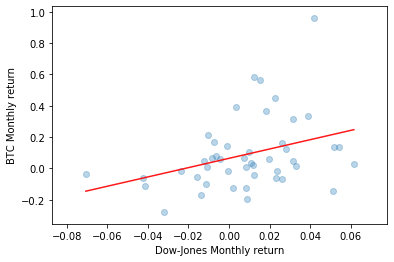

Alpha = 0.06484403269698433

R_Value = 0.3464282675018629

Slope = 2.971995182551312

Std_Err = 1.2132398915475122



In [5]:
X = DOW_return_monthly.values
Y = BTC_return_monthly.values
Alpha, Beta = linear_regression(X,Y)
X2 = np.linspace(X.min(), X.max(), 100)
Y_tilda = X2* Beta + Alpha
pl.scatter(X,Y, alpha = 0.3)
pl.xlabel("Dow-Jones Monthly return")
pl.ylabel("BTC Monthly return")
pl.plot(X2, Y_tilda, 'r', alpha = 0.9)
pl.show()
Slope, Intercept, R_Value, P_Value, Std_Err = scipy.stats.linregress(X, Y)
print("Alpha = " + str(Alpha) + "\n")
print("R_Value = " +  str(R_Value) + "\n")
print("Slope = " +   str(Slope) + "\n")
print("Std_Err = " +  str(Std_Err) + "\n")

In [6]:
dataframe = pd.concat([BTC_return_monthly, DOW_return_monthly], axis=1)

In [7]:
dataframe.columns = ['BTC-Monthly', 'Dow-Monthly']

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


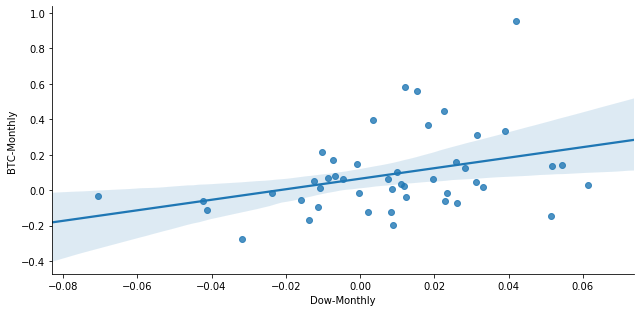

In [8]:
sns.pairplot(dataframe, x_vars=['Dow-Monthly'], y_vars='BTC-Monthly', height = 4.5, aspect = 2.0, kind='reg')

In [9]:
import pymc3 as pm
lin_model = pm.Model()

In [10]:
with lin_model:
    intercept = pm.Normal('intercept',mu=0, sd = 20)
    beta = pm.Normal('beta',0, sd = 20)
    sigma = pm.HalfCauchy('sigma', beta = 10)
    likelihood = pm.Normal('Y', mu = intercept + beta * DOW_return_monthly, sd = sigma, observed = BTC_return_monthly)
    trace = pm.sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, intercept]
Sampling 2 chains: 100%|██████████| 7000/7000 [00:05<00:00, 1263.45draws/s]


<Figure size 504x504 with 0 Axes>

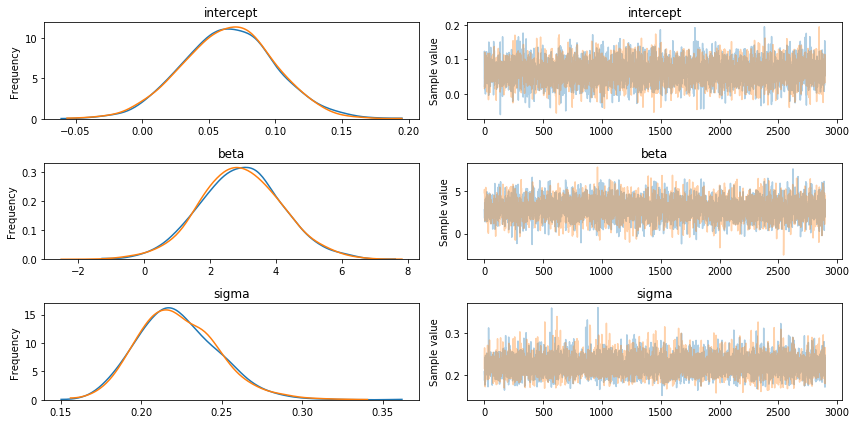

In [11]:
pl.figure(figsize=(7, 7))
pm.traceplot(trace[100:])
pl.tight_layout();

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1216d6780>,
      dtype=object)

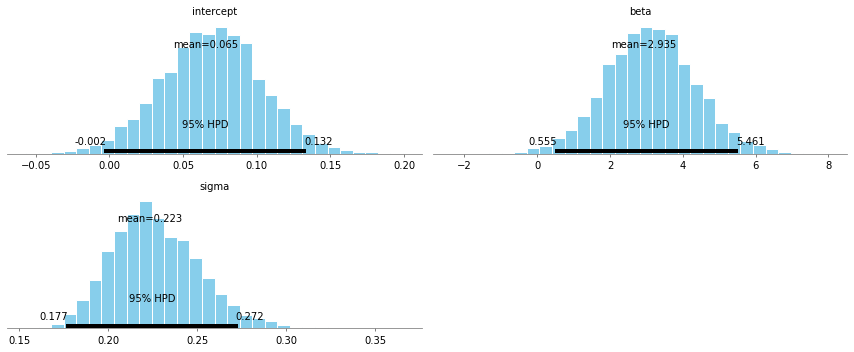

In [12]:
pm.plot_posterior(trace)

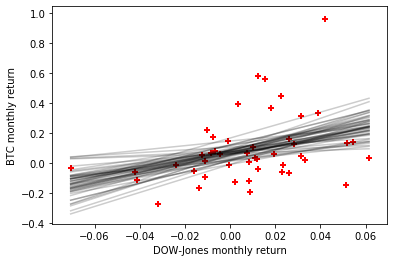

In [13]:
import numpy as np
n_samples = 500
x_range = np.linspace(DOW_return_monthly.min(),DOW_return_monthly.max())


for i in np.arange(n_samples,step=10):
    yhat = trace['intercept'][i] + trace['beta'][i] * x_range
    pl.plot(x_range,yhat,color='k',alpha = 0.2)
    pl.scatter(DOW_return_monthly,BTC_return_monthly,color='r',marker='+')
    pl.ylabel('BTC monthly return')
    pl.xlabel('DOW-Jones monthly return')

In [14]:
diverging = trace['diverging']
print('Number of Divergent Chains: {}'.format(diverging.nonzero()[0].size))
diverging_perc = diverging.nonzero()[0].size / len(trace) * 100
print('Percentage of Divergent Chains: {:.1f}'.format(diverging_perc))

Number of Divergent Chains: 0
Percentage of Divergent Chains: 0.0


/usr/local/lib/python3.7/site-packages/pymc3/plots/forestplot.py:318: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
/usr/local/lib/python3.7/site-packages/pymc3/plots/forestplot.py:319: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  ticks.tick2On = False


GridSpec(1, 2, width_ratios=[3, 1])

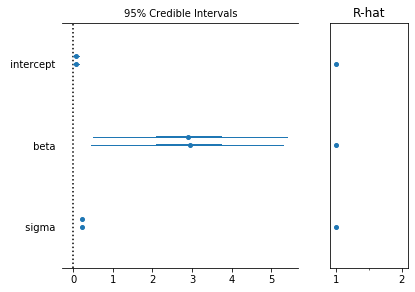

In [15]:
pm.forestplot(trace)

In [16]:
pm.summary(trace)

/usr/local/lib/python3.7/site-packages/pymc3/stats.py:982: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
intercept,0.065065,0.034529,0.000474,-0.002075,0.132043,5526.211077,0.999907
beta,2.934768,1.231204,0.015160,0.555084,5.460796,5822.594294,0.999897
sigma,0.223225,0.024847,0.000281,0.177437,0.271687,7076.639617,0.999863


In [17]:
BTC_return_monthly.shape

(46,)

In [18]:
BTC

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-01,320.434998,314.002991,320.434998,314.248993,8036550,314.248993
2015-01-02,315.838989,313.565002,314.079010,315.032013,7860650,315.032013
2015-01-03,315.149994,281.082001,314.846008,281.082001,33054400,281.082001
2015-01-04,287.230011,257.612000,281.145996,264.195007,55629100,264.195007
2015-01-05,278.341003,265.084015,265.084015,274.473999,43962800,274.473999
...,...,...,...,...,...,...
2018-11-28,4385.899902,3822.469971,3822.469971,4257.419922,7280280000,4257.419922
2018-11-29,4413.020508,4145.765137,4269.004395,4278.846680,6503347767,4278.846680
2018-11-30,4322.976562,3942.822021,4289.088867,4017.268555,6048016716,4017.268555


In [19]:
pm.summary(trace)['Rhat']

intercept    0.999907
beta         0.999897
sigma        0.999863
Name: Rhat, dtype: float64

In [20]:
pm.stats.waic(trace, model= lin_model, pointwise= False, progressbar=False)

/usr/local/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=-4.410386971734574, WAIC_se=15.802276509328316, p_WAIC=3.9768789769698594, var_warn=1)